In [201]:
# imports
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from datetime import date, timedelta
import os


In [202]:
# Dados começam 01/01/2022
# Vacinação começa 19/01/2022
# fillna(0) substitui todos os valores sem input por 0
Dados = pd.read_csv ('../dados_usados/estado.csv')
DadosGrandes = pd.read_csv ('../dados_usados/Dados_novos_BAHIA.csv')
vacinados_dados = DadosGrandes['Vacinados'].fillna(0).values
mortos_dados = Dados['deaths'].fillna(0).values
casos_dados = Dados['cases'].fillna(0).values
datas = Dados["date"].fillna(0).values
Psi = pd.read_csv('../dados_usados/psi.csv')
# Pega a lista de itens referentes aos psi do arquivo .mat 
# no terceiro index do array Psi

copy = Psi.copy()
Psi = np.append(Psi, copy)
Psi = Psi

npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

# Gerando vacinados desde o inicio da pandemia
for i in datas[:302]:
    vacinados_dados = np.insert(vacinados_dados, 0, 0)


In [203]:
# Limpando dados de vacinados
vacinados_dados_aux =  np.copy(vacinados_dados)
# Diffs menores que 0 serão substituidos pela repetição do valor anterior, tornando todo valor igual ou maior que o anterior
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados =  np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()
novos_vacinados.insert(0, 0)

In [204]:
# Ultima revisão: 05/01/2023
k = 1/4
gamma_a = 1/3.5
gamma_s = 1/4
gamma_h = 0.18
gamma_u = 0.13
mi_u = 0.4
qsi = 0.53 
h = 0.06
h_v = 0.012
mi_h = 0.15
ome_h = 0.14
ome_u = 0.29
delta = 0.31
p = 0.2

In [205]:
# def modelo 
def SEIIHURD(t, y, args):

    # t0, b0, t1, b1, t2, b2, t3, b3, t4, b4, t5, b5, b_else = args

    b0, b1, t0, t1 = args

    if t<20.178:
        beta=2.1317
    elif (t>=20.178) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 149.34736536):
        beta=1.1281
    elif (t >= 149.34736536) and (t < 245.5671023):
        beta = 1.00005674
    elif(t >= 245.5671023 and t < t0):
        beta = 1.26315674
    elif (t >= t0 and t < t1):
        beta = b0
    elif (t >= t1):
        beta = b1
    else:
        beta=1

    beta_v = beta/2

    tau = novos_vacinados[int(t)]

    if t >= 321: # 321 é quando começa a vacina
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.7
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.08
        gamma_vh=0.36
    else:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0

    N=14873064
    
    psi = Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]

In [206]:
# lq_SIR
def lq_SIR(pars, data, ts0, q0):

    b0, b1, t0, t1 = pars
    #parameters
    parode = b0, b1, t0, t1
    #calls integrator

    qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode,) ,y0=q0, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-1))
    qs = qs.y

    mortos = np.diff(qs[-3,:]*14930634)[:628]
    # casos = np.diff(qs[:, -2]*14930634)
    #define the standardized residuals
    errMortos = (mortos - data) / np.sqrt(mortos+1)
    # errCasos = (casos - np.diff(casos_dados))/np.sqrt(casos+1)
    
    return np.r_[errMortos]


In [207]:
# Condições iniciais

N=14873064

D0          = 0
N0          = 14930634
R0          = 0
H0          = 0
HV0         = 0
U0          = 0
UV0         = 0
V0          = 0
Rv0         = 0
Is0         = 2.015439771376298e-06
Ia0         = 1.8028646508967777e-06
Iav0        = 1.8028646508967777e-06 
Isv0        = 1.8028646508967777e-06 
E0          = 1.7639153732952095e-06
Ev0         = 1.7639153732952095e-06
S0          = (1-Is0-Ia0-E0)
Sv0         = 0 
Nw0         = 0
NwV0        = 0

condicoes_iniciais = [S0,E0,V0, Sv0, Ev0, Ia0, Is0, Iav0, Isv0, H0, HV0, U0, UV0, R0, Rv0, D0, Nw0, NwV0]

In [208]:
# Best Fit
def Best_Fit(data,n_tries, ts0, q0):

    # #DEEFINE THE INTERVALS OF PARS[0, 2.],[0, 2.], [0, 5.], [0, 5.],[0, 5.],[0, 80], [80, 170], [170, 240], [240, 400]  310
    intervals = np.array([[0, 5.], [0, 5.], [235.35360580, 400], [401, 628]])
    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0
    for i in range(n_tries):
        if i%5 == 0:
            print(i)
            
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])

        try:
            res = least_squares(lambda pars: lq_SIR(pars,data, ts0, q0), par0, bounds=(intervals[:,0], \
                                            intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1

                    print('achou',aj)
        except Exception as exp:
            print(exp)
            pass
                #in does not converge, do nothing

    return best_pop

In [209]:
window_size = 7
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
  
# Loop through the array to consider
# every window of size 3
while i < len(mortos_dados) - window_size + 1:
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = mortos_dados[i : i + window_size]
  
    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

In [210]:
#Run the minimizer

n_tries=100  #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
ts0 =  np.arange(len(novos_vacinados)-1)


# best_pop=Best_Fit(np.diff(moving_averages), n_tries, ts0, condicoes_iniciais)
# b0, b1, t0, t1 = best_pop
parode = [ 1.5864754 ,   3.5051942 , 317.72001799, 435.15640895]

# TEMPO FOI OTIMIZADO TAMBÉM 

#parode = [  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895]
# calls integrator
qs = solve_ivp(fun=SEIIHURD, t_span=[0, len(novos_vacinados)-1], args=(parode,) ,y0=condicoes_iniciais, dense_output=True, method="RK45",  t_eval=np.arange(len(novos_vacinados)-1))
qs = qs.y

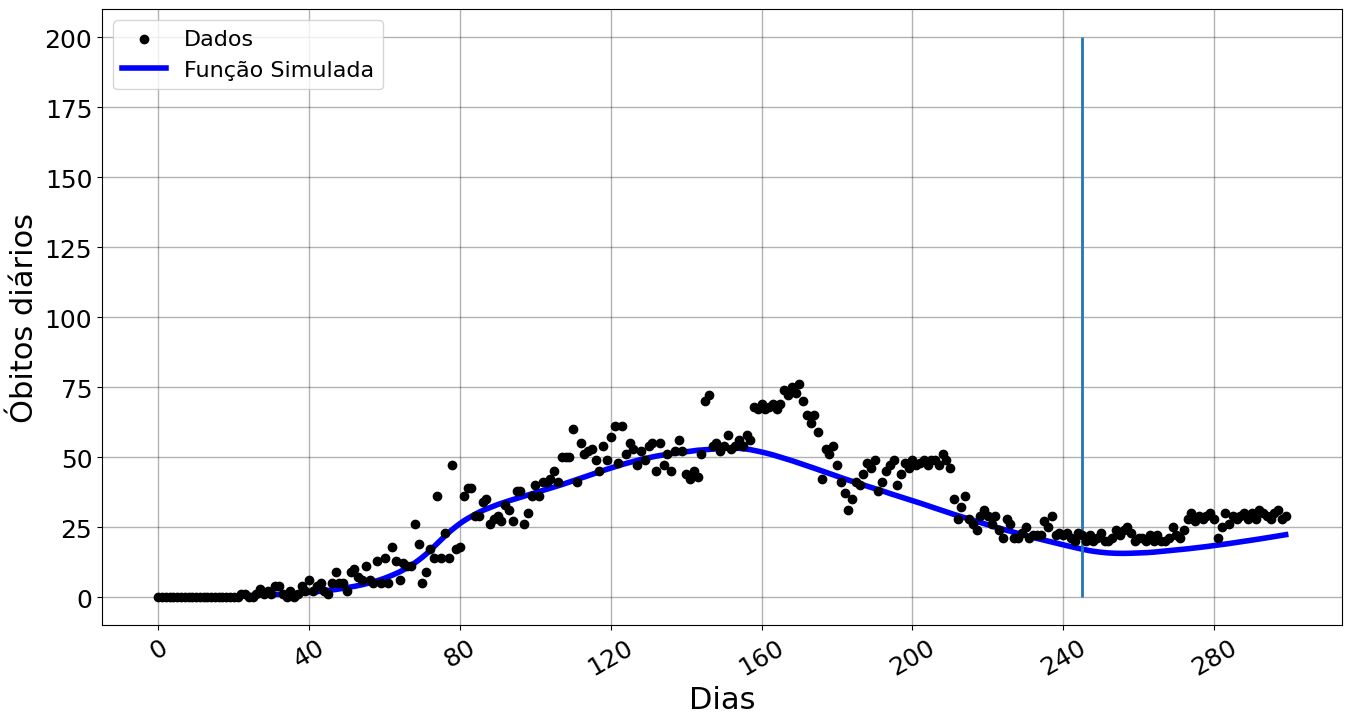

In [211]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-3,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(datas[:301])-1, 1)

ax.scatter(x_para_escala,  np.diff(mortos_dados)[:len(x_para_escala)], color='black',zorder=3,label='Dados')
#Plot the fitted function as a line.
ax.plot(x_para_escala, np.diff(N*qi)[:len(x_para_escala)],color='blue',label='Função Simulada', linewidth=4)
#Set the labels
ax.set_ylabel('Óbitos diários',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)

plt.vlines([245], ymin=0, ymax=200, linewidth=2)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)

plt.legend(loc=2, prop={'size': 16})

#Show Graph       
plt.show()

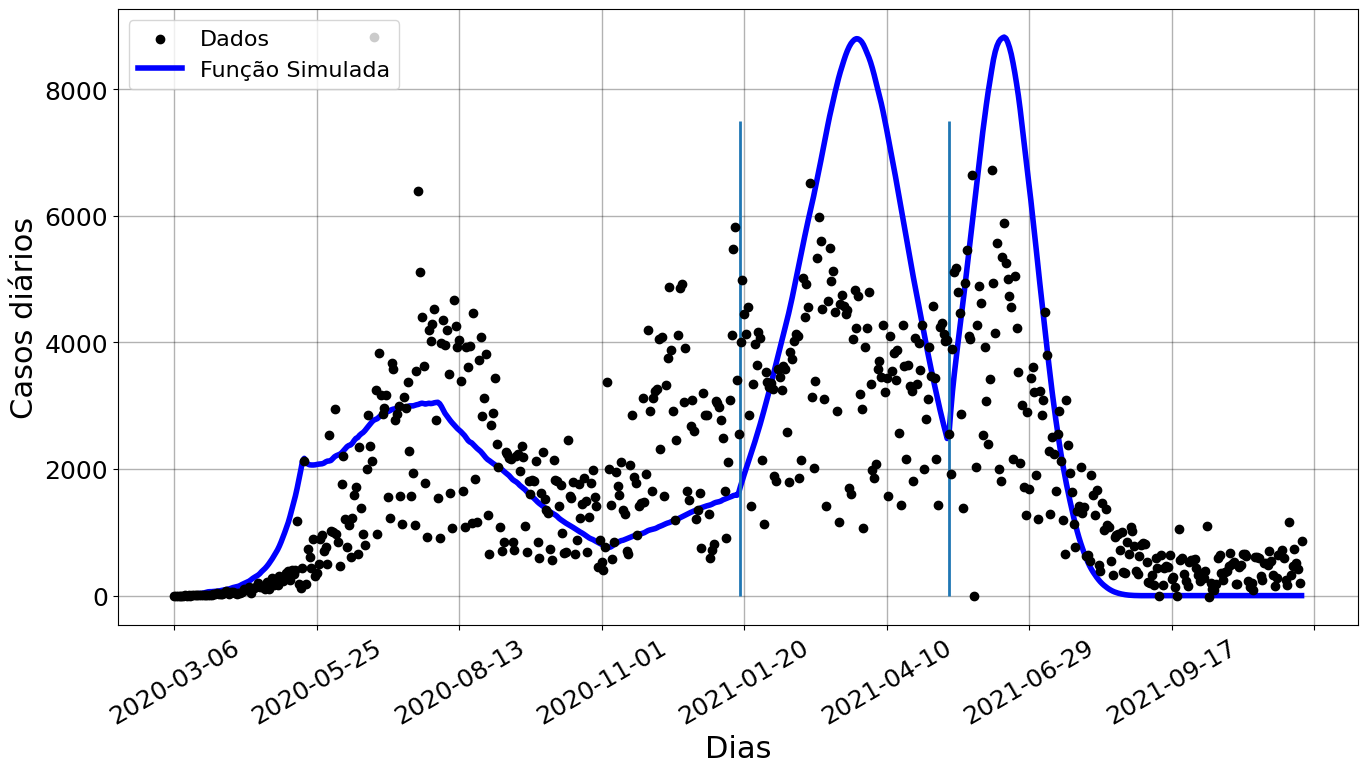

In [212]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[-2,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(datas)-1, 1)

ax.scatter(datas[:-1],  np.diff(casos_dados)[:len(datas)], color='black',zorder=3,label='Dados')

#Plot the fitted function as a line.
ax.plot(datas[:-1], np.diff(N*qi)[:len(datas)],color='blue',label='Função Simulada', linewidth=4)
#Set the labels
ax.set_ylabel('Casos diários',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)
plt.vlines([317.72001799, 435.15640895], ymin=0, ymax=7500, linewidth=2)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
plt.setp(ax.get_xticklabels(), rotation=30)
plt.legend(loc=2, prop={'size': 16})


#Show Graph       
plt.show()

NameError: name 'infec' is not defined

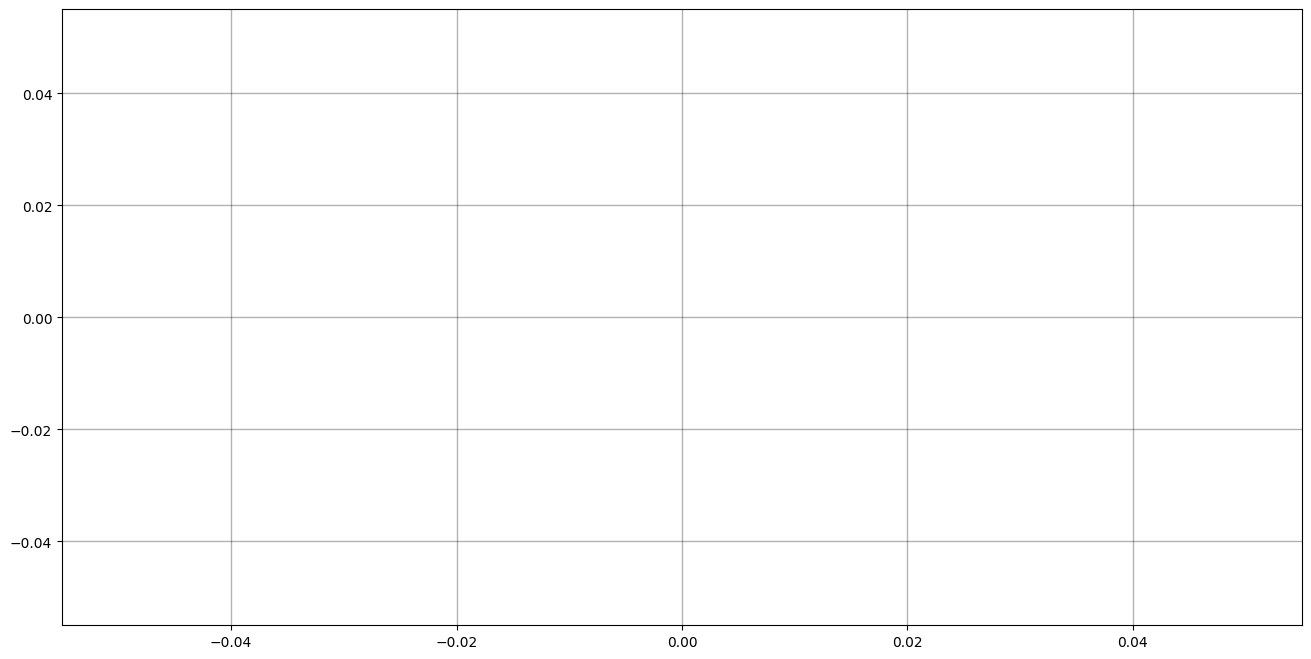

In [213]:
# plotando mortes
ts0 =  np.arange(len(novos_vacinados)-1)

qi = qs[6,:] #mortes acumulados

#Criando plot
fig, ax = plt.subplots(figsize=(16,8))

#Desenhando grid no plot
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)
ax.autoscale()

x_para_escala = np.arange(0, len(datas), 1)

ax.scatter(x_para_escala,  (infec)[:len(datas)], color='black',zorder=3,label='Reported data')

#Plot the fitted function as a line.
# ax.plot(x_para_escala, (N*qi)[:len(datas)],color='blue',label='Fitted function')
#Set the labels
ax.set_ylabel('Infectados    ',fontsize=22)
ax.set_xlabel('Dias', fontsize=22)
#Set the title
#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#Rotating the dates for better visualization
# plt.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
plt.show()

In [214]:
# best_pop
#array([  1.5864754 ,   3.5051942 , 317.72001799, 435.15640895])